In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import _rebuild
import pprint


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder  # 独热编码
from sklearn.model_selection import KFold,RepeatedKFold # 交叉训练集是多少
from scipy import sparse  # 稀疏矩阵的一个包
# from sklearn.metrics import mean_squared_error
#    指的是调用一个计算MES（平均方差的函数）
# lightgbm：
# xgboost：

# 显示所有列
pd.set_option('display.max_columns', None)

# 显示所有行
pd.set_option('display.max_rows', None)

In [2]:
# 导入数据
train_data = pd.read_csv("D:\\program_tools\\jupyter\\tianchi\\happiness_train_abbr.csv", encoding='ISO-8859-1')

test_data = pd.read_csv("D:\\program_tools\\jupyter\\tianchi\\happiness_test_abbr.csv", encoding='ISO-8859-1')

# 1.数据集的查看与分析

In [ ]:
train_data.head(5)

In [ ]:
train_data.shape,test_data.shape

- 训练集样本数8000，特征数42； 测试集样本数2968，特征数41.

In [ ]:
train_data.info()

In [ ]:
test_data.info()

In [ ]:
train_data.corr()

In [ ]:
abs(train_data.corr()["happiness"][abs(train_data.corr().happiness)>0.05]).sort_values(ascending = False)

#### 得出结论：
    - 1.数据类型均为float64(5), int64(35), object(1)，其中有survey_time为object
    - 2.数据量丢失情况：
      - 训练集：
        work_status        2951 non-null float64
        work_yr            2951 non-null float64
        work_type          2951 non-null float64
        work_manage        2951 non-null float64
        family_income      7999 non-null float64
      - 测试集：
        work_status        1078 non-null float64
        work_yr            1078 non-null float64
        work_type          1079 non-null float64
        work_manage        1079 non-null float64
    - 3.相关性：
       - 通过热点图发现  work_status  work_yr  work_type  work_manage相关性很差

In [ ]:
# 创建画布
fig = plt.figure(figsize=(12,8))
# annot: 默认为False，为True的话，会在格子上显示数字
# vmax, vmin: 热力图颜色取值的最大值，最小值，默认会从data中推导
# 设置颜色模板
sns.heatmap(train_data.corr(), vmax=1.0, vmin=-1.0, cmap=sns.color_palette('RdBu',n_colors=128))
plt.show()

#### 通过图形的方式查看异常值的分布情况

In [4]:
# 计算各列为负数的情况，并通过字典的方式保存
def negative_number( *args,data):
    difference_dict = {}
    for name in args:
        data = data.drop([name],axis=1)  # 这里用来删除指定列的数据
    for column in data:
        num = 0 # 每一列小于0的个数
        for each_value in data[column]:
            if each_value < 0:
                num +=1
            difference_dict["{}".format(column)] = num # 把每一列小于零的情况以键值对的形式保存下来
    return difference_dict   

In [ ]:
# 计算各列为负数的情况，并通过字典的方式保存
# difference_dict = {}
# type(difference_dict)

# train_data_temp = train_data.drop(["survey_time"],axis=1)  # 删除object类型的数据
# for column in train_data_temp:
#     num = 0 # 每一列小于0的个数
#     for each_value in train_data_temp[column]:
#         if each_value < 0:
#             num +=1
#     difference_dict["{}".format(column)] = num # 把每一列小于零的情况以键值对的形式保存下来
# difference_dict 

In [5]:
train_dict = negative_number("survey_time",data=train_data)
test_dict = negative_number("survey_time",data=test_data)
# pprint.pprint(train_dict)
# pprint.pprint(test_dict)
# 用字典的key来作为行创建DataFrame
data1 = pd.DataFrame.from_dict(train_dict, orient="index")
data2 = pd.DataFrame.from_dict(test_dict, orient="index")
# print(data1)
# 添加一个index列
data1=data1.reset_index()
data2=data2.reset_index()
# 将数据的指定列修改名字
data1 = data1.rename(columns={'index':'feature'})
data2 = data2.rename(columns={'index':'feature'})
# print(data1)
# print(data2)

In [ ]:
# 显示数据
c = pd.merge(data1,data2,on='feature',how='left')
c

In [ ]:
c.fillna(0,inplace=True)
# 将数据集合的两个列重新命名
c.rename(columns={'0_x':'train_data','0_y':'test_data'},inplace=True)


# 创建画布层
fig = plt.figure(figsize=(15,8))
# 绘制直方图
# x轴名字，形状为bar，尺寸为（12,4），x轴的字体倾斜50°
c.plot(x='feature',kind='bar',figsize=(12,4),rot=50)
# 显示图像
plt.show()

- 根据图表进行负值的基本处理
    - 发现问题：
        - inc_ability 的负值相对最多，happiness也存在异常值
    - 解决方案：
        - 目标变量中为负值的行直接删除
        - 连续型变量用0替代
            - family_m: 家庭人口
            - income: 去年全年的总收入
            - family_income: 去年全年家庭总收入
            - house: 现拥有几处房产
        - 离散型的特征的负值直接用中位数替代
            - 其他均为离散型变量

- 训练集

In [3]:
# 现将负值赋值为Nan   
cols = list(train_data.columns)
del cols[cols.index('survey_time')]  # 去掉时间行
for name in cols:
    train_data.loc[train_data[name]<0,name] = np.nan

# 将happiness中的异常值所在的行删除
train_data.dropna(subset=["happiness"], inplace=True, axis=0)
# 将连续型变量用0代替
train_data[['family_m', 'income', 'family_income', 'house']].fillna(0)
# 将离散型变量用中位数代替
train_data.fillna(train_data.median(), inplace=True)
# 查看处理后的数据
train_data[['family_m', 'income', 'family_income', 'house']].head(10)


,family_m,income,family_income,house
0,2.0,20000.0,60000.0,1.0
1,3.0,20000.0,40000.0,1.0
2,3.0,2000.0,8000.0,1.0
3,3.0,6420.0,12000.0,1.0
4,4.0,20000.0,40000.0,1.0
5,2.0,5000.0,5000.0,1.0
6,3.0,20000.0,40000.0,1.0
7,2.0,20000.0,40000.0,1.0
8,1.0,1600.0,1600.0,1.0
9,5.0,60000.0,60000.0,1.0


- 测试集

In [4]:
cols = list(train_data.columns)

del cols[cols.index("happiness")]# 测试集合中没有happiness，
del cols[cols.index('survey_time')]  # 去掉时间行
for name in cols:
    test_data.loc[test_data[name]<0,name] = np.nan
# 因为测试集中不存在异常值，所以无需处理
# 将连续型变量用0代替
test_data[['family_m', 'income', 'family_income', 'house']].fillna(0)
# 将离散型变量用中位数代替
test_data.fillna(test_data.median(), inplace=True)
# test_data[['family_m', 'income', 'family_income', 'house']].head(10)


In [ ]:
# 数据清洗数据导出
# train_data.to_csv("D:\\program_tools\\jupyter\\tianchi\\train_clean.csv")
# test_data.to_csv("D:\\program_tools\\jupyter\\tianchi\\test_clean.csv")

# train_data.corr().to_csv("D:\\program_tools\\jupyter\\tianchi\\train_data_corr.csv")

4.0    2888
5.0     850
3.0     697
2.0     259
1.0      51
Name: happiness, dtype: int64

# 2.逐列分析

## 2.1happiness分析

    - 总的来说，您觉得您的生活是否幸福
        - 1 = 非常不幸福; 
        - 2 = 比较不幸福;
        - 3 = 说不上幸福不幸福;
        - 4 = 比较幸福;
        - 5 = 非常幸福; 

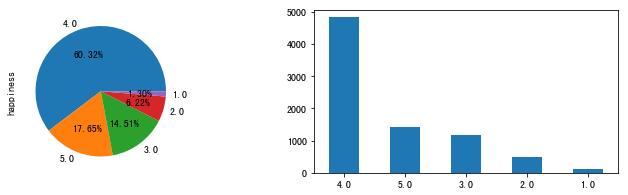

In [15]:
# 创建一个一行两列,第一个为画布，第一个为一个画布，第二个为子图数组对象
# 先算出happiness的数据分布情况
# 然后跟数据情况绘制饼图，保留小数点后保留2位，使用第一个画布
# 根据数据情况绘制柱状图，使用第二个画布， rot=0下标的显示为水平
fig,ax = plt.subplots(1,2,figsize=(12,3))
train_data.happiness.value_counts().plot(kind="pie", autopct='%.2f%%', ax=ax[0])
train_data.happiness.value_counts().plot(kind="bar", ax=ax[1], rot=0)

In [20]:
d = {1:0,2:0,3:0,4:1,5:1}  # 创建为一个新的二分类特征happiness_
train_data['happiness_new'] = train_data.happiness.map(d)

 - 可以发现幸福指数为4的人最多，4,5大约有80%，幸福感为1,2,3的大约有20%。
     - 所以估计有4/5的人认为很幸福，1/5的人不幸福
 - 所以可以将happiness值为4,5位幸福一类，happiness=1,2,3的归为不幸福一类。
 - 结论：
     - 将happiness创建为一个新的二分类特征happiness_new,用与对其它特征判定是否幸福简化分析
         - 0：不幸福；
         - 1：幸福；
         
 

## 2.2 survey_type 城市类型
- 样本类型
    - 1 = 城市; 2 = 农村;

4.0    2888
5.0     850
3.0     697
2.0     259
1.0      51
Name: happiness, dtype: int64
[1930  560  462  238   53]


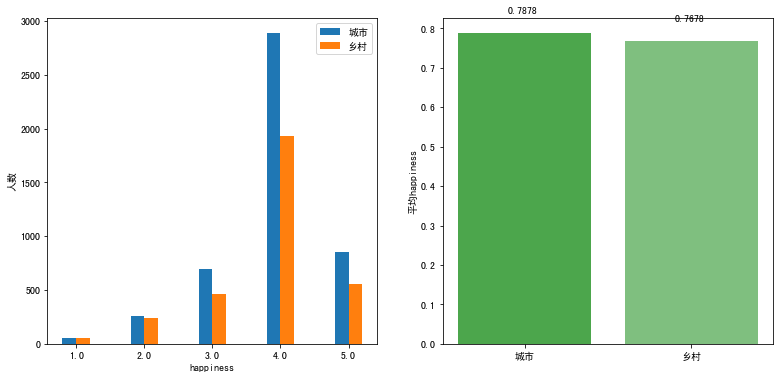

In [28]:
# 创建主画布
fig = plt.figure(figsize=(13,6))


# *********************************一*************************************。
#1. 计算出城市的happiness分布情况--计算数据
s1 = train_data[train_data["survey_type"]==1.0].happiness.value_counts()
print(s1)# 城市happiness的分布情况
s2 = train_data[train_data["survey_type"]==2.0].happiness.value_counts()
print(s2.values)# 乡村happiness的分布情况

#2. 创建子画布，1,2列，子画布处于第一列
ax1 = fig.add_subplot(121)

# 3.填充数据，绘制图表
x_label_name = [1.0 ,2.0, 3.0, 4.0, 5.0]
x = range(len(x_label_name))
plt.bar(x, s1.sort_index().values, width=0.2, label="城市")
plt.bar([i+0.2 for i in x], s2.sort_index().values, width=0.2, label="乡村")

plt.legend()
# 修改刻度
plt.xticks([i+0.1 for i in x], x_label_name)
plt.xlabel("happiness")
plt.ylabel("人数")





# **************************************二**********************************。
# 1.比较城乡的平均happiness差距
ave_happiness = train_data.groupby("survey_type")["happiness_new"].mean()

# 创建第二个子画布
ax2 = fig.add_subplot(122)

# 3.绘制图形
b1 = plt.bar(0, ave_happiness[1], color='g', alpha=0.7) # b1为第一根柱形条
b2 = plt.bar(1, ave_happiness[2], color='g', alpha=0.5) # b2为第二根柱形条
x_label_values = ['城市', '乡村']
x = range(len(x_label_values))
plt.xticks(x, x_label_values )
plt.ylabel("平均happiness")

# 设置bar上的数值
for b in b1+b2:
    h = b.get_height()# 获取y坐标
    ax2.text(b.get_x()+b.get_width()/2-0.1,  h+0.05,  '%.4f'%h)
# 4.显示图表
plt.show()

- 城市人口相对更多
- 农村和城市的幸福感分布情况基本一致
- 农村和城市的平均happiness几乎相等
- 结论：
    - 幸福基本不受居住是城市还是乡村的影响

### 2.3 province city county  省/市/县

In [ ]:
# 因为表中数据没有给定市级和县级的分类详情，所以去省进行分析，忽略其他情况

In [ ]:
# 求所有省的省平均happiness指数
# 1.求数据
ave_pro_happiness = (train_data.groupby("province")["happiness_new"].mean().sort_values())
ave_pro_happiness  
# 2.绘制画布层
fig = plt.figure(figsize=(12,3))

# 3.制作图像
ss = "1 = 上海市; 2 = 云南省; 3 = 内蒙古自治区; 4 = 北京市; 5 = 吉林省; 6 = 四川省; 7 = 天津市; 8 = 宁夏回族自治区; 9 = 安徽省; 10 = 山东省; 11 = 山西省; 12 = 广东省; 13 = 广西壮族自治区; 14 = 新疆维吾尔自治区; 15 = 江苏省; 16 = 江西省; 17 = 河北省; 18 = 河南省; 19 = 浙江省; 20 = 海南省; 21 = 湖北省; 22 = 湖南省; 23 = 甘肃省; 24 = 福建省; 25 = 西藏自治区; 26 = 贵州省; 27 = 辽宁省; 28 = 重庆市; 29 = 陕西省; 30 = 青海省; 31 = 黑龙江省"
tt = ss.split(";")
province_list = list(map(lambda x:x[len('1 = '):].strip("=").strip(),tt))
# province_list保存的是所有省份的名字

pprint.pprint(ss.split(";"))
ave_pro_happiness.plot(kind="bar", rot=0)

# 4.显示图像
plt.show()

- 可以看出内蒙古、山东省、辽宁省等北方城市的人相对幸福感更高
- 可以看到四川省、广西壮族自治区、宁夏回族自治区等地区的人相对幸福感较低
- 全体幸福感处于0.6—1.0之间，可以进行再分类为
   - 超过0.8±3%为上等，类别3,4,5,7,10,11,15,17,18,19,23,27    
       - 重命名为3
   - 等于0.8±3%为中等，类别5,9,16,17,23,30              
       - 重命名为2
   - 低于0.8±3%为下等，类别1,2,6,8,12,13,21,22,24,26,28,29,31
       - 重命名为1

In [9]:
# 训练集重新分类
train_data.province.replace([1,2,6,8,12,13,21,22,24,26,28,29,31],1,inplace = True)
train_data.province.replace([5,9,16,17,23,30],2,inplace = True)
train_data.province.replace([3,4,7,10,11,15,18,19,27],3,inplace = True)


# 测试集重新分类
test_data.province.replace([1,2,6,8,12,13,21,22,24,26,28,29,31],1,inplace = True)
test_data.province.replace([5,9,16,17,23,30],2,inplace = True)
test_data.province.replace([3,4,7,10,11,15,18,19,27],3,inplace = True)

train_data.province.value_counts()

1.0    3874
3.0    2724
2.0    1390
Name: province, dtype: int64

In [ ]:
fig,ax = plt.subplots(2,3, figsize=(12,8))
# 按照happiness进行分类
train_data[train_data.province==1]["happiness"].value_counts().plot(kind="pie", ax=ax[0][0],autopct="%.2f%%",title="1类省份")
train_data[train_data.province==2]["happiness"].value_counts().plot(kind="pie", ax=ax[0][1],autopct="%.2f%%",title="2类省份")
train_data[train_data.province==3]["happiness"].value_counts().plot(kind="pie", ax=ax[0][2],autopct="%.2f%%",title="3类省份")

# 按照happiness_new进行分类
train_data[train_data.province==1]["happiness_new"].value_counts().plot(kind="pie", ax=ax[1][0],autopct="%.2f%%",title="1类省份")
train_data[train_data.province==2]["happiness_new"].value_counts().plot(kind="pie", ax=ax[1][1],autopct="%.2f%%",title="2类省份")
train_data[train_data.province==3]["happiness_new"].value_counts().plot(kind="pie", ax=ax[1][2],autopct="%.2f%%",title="3类省份")

 - 可以分析出第3类省份数据幸福感更加强烈

### 2.4 edu 目前的最高教育程度（包括目前在读的） 

- 目前的最高教育程度（包括目前在读的） 
    - 1 = 没有受过任何教育; 2 = 私塾、扫盲班; 3 = 小学; 4 = 初中; 5 = 职业高中;
    - 6 = 普通高中; 7 = 中专; 8 = 技校; 9 = 大学专科（成人高等教育）; 
    - 10 = 大学专科（正规高等教育）; 11 = 大学本科（成人高等教育）; 
    - 12 = 大学本科（正规高等教育）; 13 = 研究生及以上; 14 = 其他; 

In [ ]:
# 按照列edu的不同来进行绘制
# map填充数据直方图，填充数据为happiness
# 
g=sns.FacetGrid(train_data,col='edu',col_wrap=4,sharex=False,sharey=False)
g.map(plt.hist,'happiness')

- 可以看出社会幸福感觉大多数分布差不多
- 按照学历进行分类
    - 基本教育      1 ：【1,2,3,4,5,6】
    - 技术教育与本科  2 ：【7,8,9,10,11,12】
    - 研究生       3：【13】
    - 其他         4：【14】

In [10]:
# edu的重分类
train_data.edu.replace([1,2,3,4,5,6], 1, inplace=True)
train_data.edu.replace([7,8,9,10,11,12], 2, inplace=True)
train_data.edu.replace([13], 3, inplace=True)
train_data.edu.replace([14], 4, inplace=True)


test_data.edu.replace([1,2,3,4,5,6], 1, inplace=True)
test_data.edu.replace([7,8,9,10,11,12], 2, inplace=True)
test_data.edu.replace([13], 3, inplace=True)
test_data.edu.replace([14], 4, inplace=True)

In [ ]:
test_data.edu.value_counts()

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(12,8))

train_data[train_data.edu==1].happiness.value_counts().plot(kind="pie", ax=ax[0][0],autopct="%.2f%%",title="基本教育1")
train_data[train_data.edu==2].happiness.value_counts().plot(kind="pie", ax=ax[0][1],autopct="%.2f%%",title="技术教育与本科2")
train_data[train_data.edu==3].happiness.value_counts().plot(kind="pie", ax=ax[1][0],autopct="%.2f%%",title="研究生3")
train_data[train_data.edu==4].happiness.value_counts().plot(kind="pie", ax=ax[1][1],autopct="%.2f%%",title="其他4")
print(train_data[train_data.edu==1].shape[0])  # 每一个类型的人口数
print(train_data[train_data.edu==2].shape[0])
print(train_data[train_data.edu==3].shape[0])
print(train_data[train_data.edu==4].shape[0])

- 人数分布：
    - 基本教育1：6285人
    - 技术教育与本科2：1618人
    - 研究生3：79人
    - 其他4：6人 （人数太少，忽略不计）
- 分析结果：
    - 能看出随着学历的上升，评分幸福4,5的人数比例在逐渐增加
    - 也就是说，学历越高，幸福感想相对越高
    

### 2.5 political 政治上

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
train_data[train_data.political==1.0].happiness.value_counts().plot(kind="bar",ax=ax[0][0],title="群众")
train_data[train_data.political==2.0].happiness.value_counts().plot(kind="bar",ax=ax[0][1],title="共青团员")
train_data[train_data.political==3.0].happiness.value_counts().plot(kind="bar",ax=ax[1][0],title="民主党派")
train_data[train_data.political==4.0].happiness.value_counts().plot(kind="bar",ax=ax[1][1],title="共产党员")

In [ ]:
print(train_data[train_data.political==1.0].shape[0])
print(train_data[train_data.political==2.0].shape[0])
print(train_data[train_data.political==3.0].shape[0])
print(train_data[train_data.political==4.0].shape[0])

In [ ]:
# 将四种身份的人，平均happiness比较
train_data.groupby("political").happiness_new.mean().plot(kind="bar", rot=0)

In [11]:
# 其他党派，人数太少，合并于4
train_data.political.replace([3.0], 4.0, inplace=True)
test_data.political.replace([3.0], 4.0, inplace=True)

- 政治人群分布情况
  - 群众:6748人
  - 共青团员:401人
  - 民主党派:11人（人数太少，忽略不计，并入共产党员）
  - 共产党员:828人
- 分析结果：
  - 1 群众身份的人中幸福感较低，
  - 4 共产党员身份的幸福感较高
  - 不同政治身份的人的幸福感也会存在较大差距
  
  现在人群只含有
      ： 群众，团员，共产党员
 
    

### 2.6 age 年龄
    - 年龄为填写问卷时间 - 出生时间

In [ ]:
# 新增年龄列
def age(data):
    data['survey_time'] = pd.to_datetime(data['survey_time'])
    data.survey_time = pd.DatetimeIndex(data.survey_time).year
    data['age']=data.survey_time-data.birth
    return data
train_data=age(train_data)
test_data=age(test_data)

### 2.7 宗教

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(12,8))
train_data[train_data.religion==0].happiness.value_counts().plot(kind="pie",  autopct="%.2f%%", ax=ax[0][0], title="不信仰宗教")
train_data[train_data.religion==1.0].happiness.value_counts().plot(kind="pie",  autopct="%.2f%%", ax=ax[0][1], title="信仰宗教")

train_data[train_data.religion==0].happiness_new.value_counts().plot(kind="pie",  autopct="%.2f%%", ax=ax[1][0], title="不信仰宗教")
train_data[train_data.religion==1.0].happiness_new.value_counts().plot(kind="pie",  autopct="%.2f%%", ax=ax[1][1], title="信仰宗教")

- 按照happiness来说，信仰宗教的happiness分布情况差不多
- 按照happiness_new来说,可以看到【不信仰宗教】的整体幸福度更高


### 2.8 depression  在过去的四周中您感到心情抑郁或沮丧的频繁程度

    - 1 = 总是; 2 = 经常; 3 = 有时; 4 = 很少; 5 = 从不;

In [ ]:
train_data.depression.value_counts()
g = sns.FacetGrid(train_data, col="depression", col_wrap=3, sharex=False, sharey=False)
g.map(plt.hist, "happiness")
plt.show()

In [ ]:
train_data.groupby("depression").happiness.mean().sort_values().plot(kind="bar", rot=0)

- 结果分析：
    - 可以看出该幸福的随着人的沮丧度越低，幸福度越高
        - 也就是心情好，幸福感就更高
        - 也就是心情不好，幸福感就越低

### 2.9 family_status 家庭经济状况
    1 = 远低于平均水平; 2 = 低于平均水平; 3 = 平均水平; 4 = 高于平均水平; 5 = 远高于平均水平; 

In [ ]:
# 添加画板层
g = sns.FacetGrid(train_data, col="family_status", col_wrap=4, sharex=False, sharey=False)
# 填充图形
g.map(plt.hist,"happiness")
# 显示图像
plt.show()

In [ ]:
train_data.groupby("family_status").happiness_new.mean().sort_values().plot(kind="bar", rot=0)
plt.show()

- 结果分析：
    - 家庭经济状况越好的人群中，幸福度整体就越高

### 2.10 class 目前处于哪个等级上
    1 = 1(最底层); 10 = 10(最顶层); 

In [ ]:
# 绘制画布层
g = sns.FacetGrid(train_data, col="class", col_wrap=3, sharex=False, sharey=False)
# 绘制图线
g.map(plt.hist, "happiness")
plt.show()

In [ ]:
train_data.groupby("class").happiness_new.mean().sort_values().plot(kind="bar", rot=0)
plt.show()

In [12]:
# 分类处理,将10种人中结果相近的合并为同一个集合

train_data["class"].replace([1,2], 1, inplace=True) # 第一类 class={1,2}
train_data["class"].replace([3], 2, inplace=True)  # 第一类 class={3}
train_data["class"].replace([4], 3, inplace=True)  # 第一类 class={4}
train_data["class"].replace([5,6,7,8,9,10], 4, inplace=True)  # 第一类 class={5,6,7,8,9,10}

test_data["class"].replace([1,2], 1, inplace=True) # 第一类 class={1,2}
test_data["class"].replace([3], 2, inplace=True)  # 第一类 class={3}
test_data["class"].replace([4], 3, inplace=True)  # 第一类 class={4}
test_data["class"].replace([5,6,7,8,9,10], 4, inplace=True)  # 第一类 class={5,6,7,8,9,10}

In [ ]:
# print(train_data["class"].value_counts())
# print(test_data["class"].value_counts())

- 结果分析
    - 可以看出随着class等级越大，可以看出幸福度高的人的占比比例就越大
    - 此外，class不是越高越好，在class=7的时候，出现了顶峰值，可知：
        - class不因当越高越好，处于大概处于class=7之后就会出现一定的幸福度降低现象

### 2.11 equity 总的来说，您认为当今社会公不公平
    - 1 = 完全不公平; 2 = 比较不公平; 3 = 说不上公平但也不能说不公平;
    - 4 = 比较公平; 5 = 完全公平; 

In [ ]:
g = sns.FacetGrid(train_data, col="equity", col_wrap=3, sharex=False, sharey=False)
g.map(plt.hist, "happiness")

In [ ]:
train_data.groupby("equity").happiness_new.mean().plot(kind="bar", rot=0)
plt.show()

- 可以看出随着人对社会的认可度越高，总分来说幸福感觉就越高

### 2.12 status_peer  与同龄人相比，您本人的社会经济地位怎样
    - 1 = 较高; 2 = 差不多; 3 = 较低; 

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(12,4))
situations = ["较高","差不多","较低"]
for i in range(1,4,1):
    train_data[train_data.status_peer==i].happiness.value_counts().plot(kind="pie", autopct="%.2ff%%" ,title=situations[i-1],ax=ax[i-1],rot=0)
plt.show()

- 结果分析：
    - 从较低->差不多->较高，可发现该幸福度高的比例正在增大
- 和同龄人相比社会经济地越高，则幸福度越高

### 2.13 health 
- 您觉得您目前的身体健康状况
- 1 = 很不健康; 2 = 比较不健康; 3 = 一般; 4 = 比较健康; 5 = 很健康;

In [ ]:
g = sns.FacetGrid(train_data, col="health", col_wrap=3, sharex=False, sharey=False)
g.map(plt.hist, "happiness")
plt.show()

- 可以看出不同的health的人的幸福指数是不同的
    - 越健康的人名明显幸福感就越高
    - 健康指数是幸福感的重要指标
    

### 2.14 health_problem 
- 在过去的四周中由于健康问题影响到您的工作或其他日常活动的频繁程度
- 1 = 总是; 2 = 经常; 3 = 有时; 4 = 很少; 5 = 从不;

In [ ]:
g = sns.FacetGrid(train_data, col="health_problem", col_wrap=3, sharex=False, sharey=False)
g.map(plt.hist, "happiness")
plt.show()

 - 可以看出健康带来的问题越多，人的幸福感就越低
 - 再次凸显了健康是一种十分重要的幸福感指标

### 2.15 inc_ability
- 考虑到您的能力和工作状况，您目前的收入是否合理
- 1 = 非常合理; 2 = 合理; 3 = 不合理; 4 = 非常不合理; 

In [ ]:
g = sns.FacetGrid(train_data, col="inc_ability", col_wrap=2, sharex=False, sharey=False)
g.map(plt.hist, "happiness")
plt.show()

In [ ]:
train_data.groupby("inc_ability").happiness.mean().plot(kind="bar", rot=0)
plt.show()

- 可以很明显个的看出，收入与能力的匹配程度也严重影响幸福程度
    - 能力和工作状况与目前的收入合理程度越高，幸福指数就越高
- 所以inc_ability相对于幸福感是一个十分重要的指标因素

### 2.16 status_3_before
- 与三年前相比，您的社会经济地位发生了什么变化
- 1 = 上升了; 2 = 差不多; 3 = 下降了; 

In [ ]:
g = sns.FacetGrid(train_data, col="status_3_before",col_wrap=3,  sharex=False, sharey=False)
g.map(plt.hist, "happiness")
plt.show()

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(12,8))
situations = ["上升了", "差不多", "下降了"]
for i in range(1,len(situations)+1):
    train_data[train_data["status_3_before"]==i].happiness.value_counts().plot(kind="pie", autopct="%.2f%%", ax=ax[i-1], title=situations[i-1])
plt.show()

- status_3_before值的不同，幸福感也会存在不同的差异
- 如果经济地位上升了，生活水平会上升，幸福感就也会上升
- status_3_before是一个重要的评测指标

### 2.17 view 
- 根据您的一般印象您对一些重要事情所持的观点和看法与社会大众一致的时候有多少
- 1 = 一致的时候非常少; 2 = 一致的时候比较少; 3 = 一般; 4 = 一致的时候比较多; 5 = 一致的时候非常多; 

In [ ]:
s = sns.FacetGrid(train_data, col="view", col_wrap=3, sharex=False, sharey=False)
s.map(plt.hist, "happiness")
plt.show()

In [ ]:
train_data.groupby("view").happiness.mean().plot(kind="bar", rot=0)
plt.ylabel("happiness")
plt.show()

- 可以看出自己的观点和大众观点一致更多的时候，相对幸福感就会更高

### 2.18 relax
- 在过去一年中，您是否经常在您的空闲时间做下面的事情-休息放松
- 1 = 从不; 2 = 很少; 3 = 有时; 4 = 经常; 5 = 非常频繁; 

In [ ]:
fig ,ax = plt.subplots(1,5, figsize=(16,8))
situations = ['从不', '很少', '有时', '经常', '非常频繁']
for i in range(1, len(situations)+1):
    train_data[train_data.relax==i].happiness.value_counts().plot(kind="pie", ax=ax[i-1],autopct="%.2f%%",title=situations[i-1])

- 放松的频率越高，幸福度可能就越好
- 但是不是越频繁越好，甚至幸福度有可能会降低

### 2.19 car
- 您家是否拥有家用小汽车
- 1 = 有; 2 = 没有; 

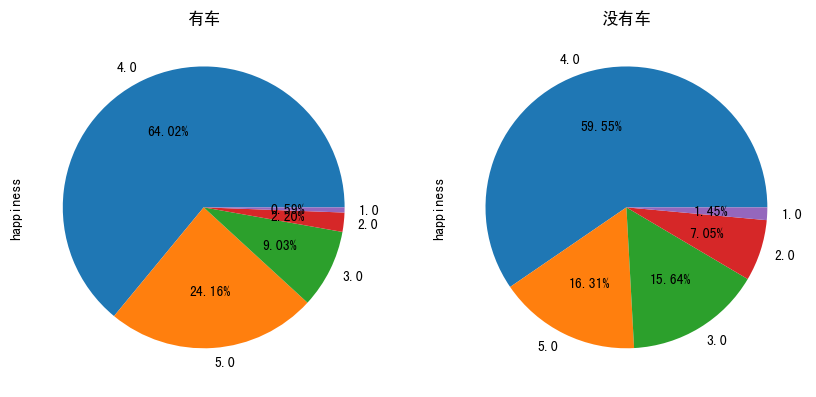

In [12]:
fig ,ax = plt.subplots(1,2, figsize=(10,7), dpi=100)
situations = ['有车', '没有车']
for i in range(1, len(situations)+1):
    train_data[train_data.car==i].happiness.value_counts().plot(kind="pie", ax=ax[i-1],autopct="%.2f%%",title=situations[i-1])

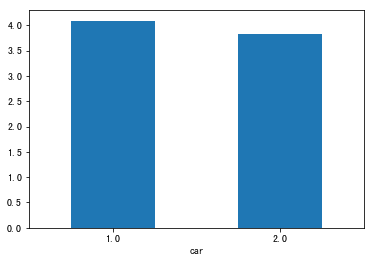

In [7]:
train_data.groupby("car").happiness.mean().plot(kind="bar", rot=0)
plt.show()

- 可以看出【有车的人】的幸福感相对比【没车】的更高
- 有无车辆这也侧面体现了个人财产，说明个人财产的影响可能会影响幸福度

### 2.20 learn
- 在过去一年中，您是否经常在您的空闲时间做下面的事情-学习充电
- 1 = 从不; 2 = 很少; 3 = 有时; 4 = 经常; 5 = 非常频繁; 

In [ ]:
g = sns.FacetGrid(train_data, col="learn", col_wrap=3, sharex=False, sharey=False)
g.map(plt.hist, "happiness")
plt.show()

In [ ]:
fig ,ax = plt.subplots(1,5, figsize=(16,8))
situations = ['从不', '很少', '有时', '经常', '非常频繁']
for i in range(1, len(situations)+1):
    train_data[train_data.learn==i].happiness_new.value_counts().plot(kind="pie", ax=ax[i-1],autopct="%.2f%%",title=situations[i-1])

- 结果分析：
    - 直方图：大多数人平时很少读书
    - 饼图： 随着读书频率增大，幸福感会渐渐上升
- 学习使我快乐

### 2.21 house
- 您家现拥有几处房产

In [ ]:
# print(train_data.house.value_counts())
fig ,ax = plt.subplots(1,2, figsize=(12,4))
train_data.house.value_counts().plot(kind="bar", rot=0, ax=ax[0])
test_data.house.value_counts().plot(kind="bar", rot=0, ax=ax[1])

 - 因为存在多套房子的人的数据太少，可以忽略，归为大于等于4套房子的人

In [13]:
# 将大于四套房子的人归为含有四套
list_temp = set(train_data[train_data.house>4].house) 
list_temp
train_data.house.replace(list(list_temp), 4, inplace=True)
train_data.house.value_counts()

1.0    6387
2.0     907
0.0     510
3.0     133
4.0      51
Name: house, dtype: int64

In [ ]:
# 查看拥有不同套房子的人的平均happiness指数
train_data.groupby("house").happiness.mean().plot(kind="bar", rot=0)
plt.show()

- 由柱状图可知：
    - 随着拥有房子的数量增多，幸福感愈发强烈
    - 拥有三套房子的人幸福感最强烈
    - 但是房子过多可能会出现折返现象，反而成为烦恼

### 2.22 weight_jin,height_cm
- 身高体重

In [ ]:
fig=plt.figure(figsize=(6,3))
sns.scatterplot('height_cm','weight_jin',hue='happiness_new',size='happiness_new',data=train_data)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,4))
sns.scatterplot('height_cm', 'weight_jin', hue="happiness_new",data=train_data)
plt.show()

- 可以看出身高体重和happiness的相关性不大
- 身高越高，体重也会越大

### 2.23 socialize
- 在过去一年中，您是否经常在您的空闲时间做下面的事情-社交
- 1 = 从不; 2 = 很少; 3 = 有时; 4 = 经常; 5 = 非常频繁; 

In [ ]:
fig ,ax = plt.subplots(2,5, figsize=(16,8))
situations = ['从不', '很少', '有时', '经常', '非常频繁']
for i in range(1, len(situations)+1):
    train_data[train_data.socialize==i].happiness.value_counts().plot(kind="pie", ax=ax[0][i-1],autopct="%.2f%%",title=situations[i-1])

for i in range(1, len(situations)+1):
    train_data[train_data.socialize==i].happiness_new.value_counts().plot(kind="pie", ax=ax[1][i-1],autopct="%.2f%%",title=situations[i-1])

- 可以看到一个人空闲时间越多，随着社交的频率越高，那么幸福度也越高
- 但是过于频繁可能会有所下降

### 2.24 hukou 户口
- 您目前的户口登记状况
- 1 = 农业户口; 2 = 非农业户口; 3 = 蓝印户口; 4 = 居民户口（以前是农业户口）;
- 5 = 居民户口（以前是非农业户口）; 6 = 军籍; 7 = 没有户口; 8 = 其他;
    - 蓝印户口，是一种介于正式户口与暂住户口之间的户籍，因公安机关加盖的蓝色印章，而称为蓝印户口

In [ ]:
g = sns.FacetGrid(train_data, col="hukou", col_wrap=4, sharex=False, sharey=False)
g.map(plt.hist, "happiness")
plt.show()

- 户口为以下类型的数量太少，合并类型：
    - 3 = 蓝印户口,
    - 6 = 军籍;
    - 7 = 没有户口;
    - 8 = 其他;

In [14]:
# 将数据量少的数据归为第一类
train_data.hukou.replace([3,6,7,8], 1, inplace=True)
test_data.hukou.replace([3,6,7,8], 1, inplace=True)

In [ ]:
train_data.groupby("hukou").happiness_new.mean().plot(kind="bar", rot=0)
plt.ylabel("happiness")
plt.show()

- 由图可知：
    - 户口之间的幸福度相差不是很大；
    - 但是农村户口转居住户口的人幸福感略有提高

### 2.25 family_m
- 家目前住在一起的通常有几人（包括您本人）

In [ ]:
train_data.family_m.value_counts()
# 可以发现家里人口数大于8的非常少

In [15]:
# 对人口分布进行重分布
train_data.family_m.replace([9,11,50,13], 8, inplace=True)
test_data.family_m.replace([9,11,50,13], 8, inplace=True)

In [ ]:
s = sns.FacetGrid(train_data, col="family_m", col_wrap=4, sharex=False, sharey=False)
s.map(plt.hist, "happiness")
plt.show()

In [ ]:
train_data.groupby("family_m").happiness.mean().plot(kind="bar", rot=0)

 - 结果分析：
     - 家里人口数为1的，幸福感相对较低
     - 其他的情况基本超不多

### 2.26 work_manage
- 您目前工作的管理活动情况
- 1 = 只管理别人，不受别人管理; 2 = 既管理别人，又受别人管理; 3 = 只受别人管理，不管理别人; 4 = 既不管理别人，又不受别人管理; 

In [ ]:
g = sns.FacetGrid(train_data, col="work_manage", col_wrap=2, sharex=False, sharey=False)
g.map(plt.hist, "happiness")
plt.show()

- 可以看出大多数人都处于他人的管理

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(12,6))
list_demo = [' 只管理别人，不受别人管理','既管理别人，又受别人管理','只受别人管理，不管理别人','既不管理别人，又不受别人管理' ]
for i in range(1,len(list_demo)+1):
    train_data[train_data.work_manage==i].happiness.value_counts().plot(kind="pie", autopct="%.2f%%", ax=ax[int((i-1)/2)][i%2],title=list_demo[i-1])

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(12,6))
list_demo = [' 只管理别人，不受别人管理','既管理别人，又受别人管理','只受别人管理，不管理别人','既不管理别人，又不受别人管理' ]
for i in range(1,len(list_demo)+1):
    train_data[train_data.work_manage==i].happiness_new.value_counts().plot(kind="pie", autopct="%.2f%%", ax=ax[int((i-1)/2)][i%2],title=list_demo[i-1])

- 可以分析出，能管理他人的人幸福感更强烈
- 而无所事事的人，和只受他人管理的人幸福感相对较低
- 也从侧面体现出，成功的人更加幸福

In [ ]:
train_data.head(100)

In [ ]:
#### 剩余机器机器学习部分，另外一个版本已经完成。